In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import  read_N_prepare_data, plot_item_ratings_freq, plot_user_ratings_freq, calc_similarity, top_neighbours
from helpers import get_item, get_items, get_user, get_users, get_user_item

# Week 1

### Data preprocessing

In [66]:
def clean_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.astype({'user_id': 'str', 'item_id': 'str', 'rating': 'float'}, copy=False)
    df.drop(['timestamp'], axis=1, inplace=True)
    print("Data points initially:", df.shape[0])
    df.drop_duplicates(inplace=True, keep='first')
    print("Data points after removing duplicates:", df.shape[0])
    
    df.dropna(inplace=True)

    # invalid user_id or item_id
    t1 = df.loc[df['item_id'] == ''].shape[0] + df.loc[df['user_id'] == ''].shape[0]
    assert t1 == 0
    print("No invalid user_id or item_id")
    # invalid ratings
    t2 = df.loc[df['rating'] < 0].shape[0] + df.loc[df['rating'] > 5].shape[0]  
    assert t2 == 0
    print("No invalid ratings")

    print("Data points after cleaning:", df.shape[0])

In [67]:
# Preapre data
df_t = pd.read_csv('data/test.tsv', sep='\t')
df = pd.read_csv('data/train.tsv', sep='\t')
# clean data
print(''.join(['-']*50))
print("Cleaning test split:")
clean_data(df_t)
print(''.join(['-']*50))
print("Cleaning training split:")
clean_data(df)
print(''.join(['-']*50))

print("Training and Test compatibility check:")


all_users_tr = set(df['user_id'])
print('users in training : ',len(all_users_tr))
all_items_tr = set(df['item_id'])
print('items in training: ',len(all_items_tr))


all_users_tst = set(df_t['user_id']) 
all_items_tst = set(df_t['item_id'])


# check if all users in test are in training
users_not_in_tr = all_users_tst.difference(all_users_tr)
print('users in test but not in training(dropping): ', len(users_not_in_tr))

# check if all items in test are in training
items_not_in_tr = all_items_tst.difference(all_items_tr)
print('items in test but not in training(dropping): ', len(items_not_in_tr))

# drop users not in training
df_t = df_t[~df_t['user_id'].isin(users_not_in_tr)]

# drop items not in training
df_t = df_t[~df_t['item_id'].isin(items_not_in_tr)]


all_users_tst = list(set(df_t['user_id']))
all_items_tst = list(set(df_t['item_id']))
print('users in test: ',len(all_users_tst))
print('items in test: ',len(all_items_tst))

#common
common_users = set(all_users_tr).intersection(all_users_tst)
common_items = set(all_items_tr).intersection(all_items_tst)
print("Common users: ", len(common_users))
print("Common items: ", len(common_items))

#all
all_users = set(all_users_tr).union(all_users_tst)
all_items = set(all_items_tr).union(all_items_tst)
print("All users: ", len(all_users))
print("All items: ", len(all_items))


test_indx = df_t.set_index(['user_id', 'item_id']).index
train_indx = df.set_index(['user_id', 'item_id']).index
overlap = 0
for u in common_users:
    for i in common_items:
        if (u,i) in test_indx and (u,i) in train_indx:
            overlap += 1
print("Overlap between training and test data: ", overlap)

print(''.join(['-']*50))
print("Final test data shape: ", df_t.shape)
print("Final training data shape: ", df.shape)





--------------------------------------------------
Cleaning test split:
Data points initially: 3000
Data points after removing duplicates: 1822
No invalid user_id or item_id
No invalid ratings
Data points after cleaning: 1822
--------------------------------------------------
Cleaning training split:
Data points initially: 11000
Data points after removing duplicates: 9913
No invalid user_id or item_id
No invalid ratings
Data points after cleaning: 9913
--------------------------------------------------
Training and Test compatibility check:
users in training :  800
items in training:  509
users in test but not in training(dropping):  0
items in test but not in training(dropping):  9
users in test:  427
items in test:  404
Common users:  427
Common items:  404
All users:  800
All items:  509
Overlap between training and test data:  0
--------------------------------------------------
Final test data shape:  (1728, 3)
Final training data shape:  (9913, 3)


### Data Statistics

In [7]:
# TEST DUPLICATES
df_t_raw = pd.read_csv('data/test.tsv', sep='\t')
df_t_raw.shape
df_t_raw.groupby(['user_id','item_id','rating','timestamp']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(5)

,user_id,item_id,rating,timestamp,count
1512,AHEJYPLN7DMCYRQ2KCWQ5YIY6JDA,B0BPKH4HB2,5.0,1669857856601,6
959,AG5CLB4M2P4GCGANQS4WS3JGHFOQ,B09R2TMLJR,5.0,1656815832888,5
1088,AGC2Y4SQPG23KHUYXHSMOKIPJVGQ,B0064RTS0G,5.0,1585166179129,5
1757,AHUIUCGSUO6B2KRQLQ2UWRYXTH5Q,B0BKR2ZM9X,5.0,1584845977235,5
767,AFNKANPQUS5G3ENXFLAJ4CHWQGFQ,B081592T7F,5.0,1587658475788,5


In [8]:
# TRAIN DUPLICATES
df_t_raw = pd.read_csv('data/train.tsv', sep='\t')
df_t_raw.shape
df_t_raw.groupby(['user_id','item_id','rating','timestamp']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(5)

,user_id,item_id,rating,timestamp,count
762,AECRFIY3HZZG5KMU424HTLAKDGFA,B07DK59QNR,5.0,1529681473598,4
202,AE3Y65VROR3YICKMO6OJJ2LLN7RQ,B09BF8XDF4,5.0,1299875655000,4
9204,AHP54DEEFACVFPIFX7KZ3P32ZYVQ,B01DE4D4LU,5.0,1519671505067,3
9829,AHYQKMLIXHKFDHC7K2Y4JXM4YLOQ,B013ZHK4DM,5.0,1523749482759,3
1187,AEHPI7DGK45GM4JO4PP25BE3RZJQ,B09396NY1C,5.0,1424281371000,3


item_id
B0BSGM6CQ9    158
B0BPJ4Q6FJ    156
B09857JRP2    143
B0BCK6L7S5    132
B08R5GM6YB    123
B0BTC9YJ2W    122
B08SJY4T7K     95
B0B95V41NR     92
B004XNK7AI     89
B09V91H5XM     85
Name: count, dtype: int64
item_id
B08Y6PVK2L    2
B073RTT48C    2
B08PBNXZYP    2
B0B63DPVDK    2
B075MCRFYZ    2
B0C5CTX5LZ    1
B0BNCDVD4M    1
B0B2LMZ9RT    1
B07DVX841V    1
B07KRZ1HH8    1
Name: count, dtype: int64


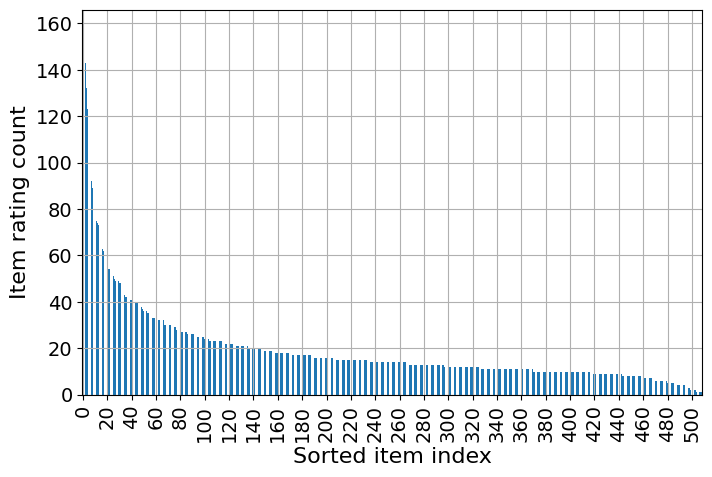

In [9]:
# ITEM RATINGS FREQUENCY
p = plot_item_ratings_freq(df)


user_id
AF7CC34DK36SQJS7WXI44DREGWJA    48
AG5ZVXXHEXDYUUODSEQC4XXV7DPA    43
AFJQQWO6VAZCTTY3GXNB3SEUU34Q    43
AGVT5E2C6WNOCFYSLOCPAPBJOIKQ    41
AG4ZLTRHVAZRU33BPY5Y643IZXPQ    40
AHR6CSQFJVG5AHI25CP4NTJDEZFQ    38
AG6ATLCKETNYRKL6GCQV35CSSGPA    36
AHJQIRE3KBRMPLVEGQNUOTYILZDA    36
AHNG3NRGEDYO7E44QMYDHMBADPBA    35
AFDAU5M5NRUN4LYLI7N4YROKYLWA    34
Name: count, dtype: int64
user_id
AHMMZCKZMV7U5SPYVE6IG2YACR7Q    2
AFFOT7AORQAWKU6KKPDHR3FOA5AA    1
AF2MGAQBAT3E4XQC7NNAQFYG4MIQ    1
AEXXX2MQRH3AHZMBZBP4RDNGRRWQ    1
AHMUAUOHLITDKIKI4C3KVRWIBMAQ    1
AESA6T5VF3ADXH5GYRX2RDMN6I6Q    1
AGMYRILPTJDOK7WL5OYHYGRYVXMQ    1
AFGJ42MV2H2CHEZNN3JPQ3RSYUHQ    1
AEMZMINSQYQBEDD3TPDQZZFFWIQA    1
AGDEYWGZKNGR36MRO7ZT3AB45AXA    1
Name: count, dtype: int64


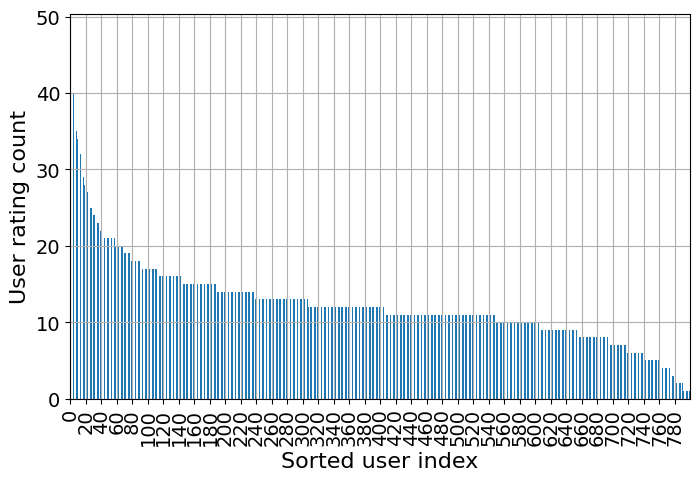

In [10]:
# USER RATINGS FREQUENCY
plot_user_ratings_freq(df)

In [11]:
# Top 5 most rated items
user_cnts = df.copy()
sums = user_cnts.groupby('item_id').sum()
top_rting_cnt_5 = user_cnts.groupby('item_id').count().sort_values(by='user_id', ascending=False).head(5)
buff = sums.loc[top_rting_cnt_5.index]
buff['rating'] = buff['rating'].values/top_rting_cnt_5['rating'].values

for i, r in buff.iterrows():
    print("Item: ", i, " Avg Rating: ", round(r['rating'], 2))
#for r_cnt in top_rting_cnt_5['rating'].values:
    


Item:  B0BSGM6CQ9  Avg Rating:  4.69
Item:  B0BPJ4Q6FJ  Avg Rating:  4.74
Item:  B09857JRP2  Avg Rating:  4.77
Item:  B0BCK6L7S5  Avg Rating:  4.3
Item:  B08R5GM6YB  Avg Rating:  4.5


# Week 2

In [4]:
#TOPOP
def topPopK(df,r,k):
    top = df.loc[df['rating'] > r].groupby(['item_id']).count().sort_values(by='rating', ascending=False).head(k)
    
    # top['item_id'] = top.index
    # top.set_index('user_id', inplace=True)
    top.reset_index(inplace=True)
    top.drop(['user_id','rating'], axis=1, inplace=True)
    return top
topPopK(df,3,10)

,item_id
0,B0BPJ4Q6FJ
1,B0BSGM6CQ9
2,B09857JRP2
3,B0BTC9YJ2W
4,B08R5GM6YB
5,B0BCK6L7S5
6,B0B95V41NR
7,B004XNK7AI
8,B09V91H5XM
9,B08SJY4T7K


## Surprise

In [31]:
#LOAD DATA
from surprise import KNNWithMeans
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import accuracy

# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data_train_pd = Dataset.load_from_df(df[["user_id", "item_id", "rating"]], reader)

# change dataformat for test
data_test = []
for i,u in df_t.iterrows():
    uid = u['user_id']
    iid = u['item_id']
    r_ui= u['rating']
    data_test.append((uid,iid,r_ui))

### KNN

In [32]:
# PARAM SEARCH
search = False
if search:
    knn_param_grid = {'k': [2, 5, 10, 15, 20],
                    'sim_options': {
                        'name': ['cosine', 'pearson'],
                        'user_based': [True]},
                    'verbose': [False]
                    }

    knn_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse'], cv=5 )
    knn_gs.fit(data_train_pd)
    knn_gs_results_df = pd.DataFrame.from_dict(knn_gs.cv_results)

    # best RMSE score
    print(knn_gs.best_score["rmse"])

    # combination of parameters that gave the best RMSE score
    bst_params = knn_gs.best_params["rmse"]
    print(bst_params)

    K = bst_params['k']
    sim_options = bst_params['sim_options']
else:
    K = 20
    sim_options = {'name': 'cosine', 'user_based': True}
knn_algo = KNNWithMeans(k=K, sim_options=sim_options)
knn_algo = knn_algo.fit(data_train_pd.build_full_trainset())

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [33]:
# Grid search results
if search:
    to_drop_cols = [ col for col in knn_gs_results_df.columns if ('time' in col) ]
    to_drop_cols += ['param_verbose','params']
    knn_gs_results_df.drop(columns=to_drop_cols, inplace=True)
    knn_gs_results_df

In [34]:
# Predict test data
knn_preds = knn_algo.test(data_test)

### SVD

In [35]:
from surprise import SVD
# PARAM SEARCH
search = False
if search:
    svd_param_grid = {'n_factors': [2, 5, 10, 15, 20, 30],
                    'n_epochs': [5, 10, 15, 20, 30],
                    'verbose': [False]
                    }

    svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse'], cv=5 )
    svd_gs.fit(data_train_pd)
    svd_gs_results_df = pd.DataFrame.from_dict(svd_gs.cv_results)

    #best RMSE score
    print(svd_gs.best_score["rmse"])

    #combination of parameters that gave the best RMSE score
    bst_params = svd_gs.best_params["rmse"]
    print(bst_params)

    n_factors = bst_params['n_factors']
    n_epochs = bst_params['n_epochs']
else:
    n_factors = 2
    n_epochs = 20

svd_algo = SVD(n_factors=n_factors, n_epochs=n_epochs)
svd_algo = svd_algo.fit(data_train_pd.build_full_trainset())

In [36]:
# Grid search results
if search:
    to_drop_cols = [ col for col in svd_gs_results_df.columns if ('time' in col) ]
    to_drop_cols += ['param_verbose','params']
    svd_gs_results_df.drop(columns=to_drop_cols, inplace=True)
    svd_gs_results_df.columns
    svd_gs_results_df

In [37]:
# Predict Test data
svd_preds = []
for i in data_test:
    pred = svd_algo.predict(uid = i[0], iid = i[1], r_ui = i[2], verbose=False)
    if pred.details['was_impossible']:
        print('User or item is unkown: \n user: ',uid,' \n item: ',iid)
    svd_preds.append(pred)

# Week 3

#### RMSE for test predictions

In [38]:
accuracy.rmse(knn_preds)
accuracy.rmse(svd_preds)
pass

RMSE: 1.0555
RMSE: 0.9721


### Recommend top 10 for test users

In [ ]:
# Train split to binary
df_t_bin = df_t.copy()
# to binary, and sort by rating
df_t_bin.sort_values(by=['user_id', 'rating'], inplace=True, ascending=[True, False])
df_t_bin.loc[df_t_bin['rating'] < 4, 'rating'] = 0
df_t_bin.loc[df_t_bin['rating'] >= 4, 'rating'] = 1
df_t_bin.set_index('user_id', inplace=True)
df_t_bin.head(10)

,item_id,rating
user_id,,
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0928HW2P4,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0B95V41NR,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B09198262S,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0B8F6LD9F,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B00CGFRJ2Y,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0BPJ4Q6FJ,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B008BPI2OW,1.0
AE23LDQTB7L76AP6E6WPBFVYL5DA,B0BG95DG2H,1.0
AE2BV2H57ERXAPW7SOAXFLWA2S2Q,B07L6RCDP7,1.0


In [40]:
# relavant items count
relevant_cnt_tst = df_t_bin.groupby(['user_id']).sum()
relevant_cnt_tst.drop(columns=['item_id'], inplace=True)
# sort
relevant_cnt_tst.sort_values(by=['rating'], inplace=True, ascending=False)
#relevant_cnt_tst.columns = ['relevant_cnt']
relevant_cnt_tst.head(5)

,rating
user_id,
AEMSFZ4NLED647BP3ZCQEY3FNGKA,23.0
AGMYRILPTJDOK7WL5OYHYGRYVXMQ,13.0
AHMMZCKZMV7U5SPYVE6IG2YACR7Q,13.0
AF2MGAQBAT3E4XQC7NNAQFYG4MIQ,13.0
AHTIEJX7M6WFSN6ZAZIAZU7UBWUA,13.0


In [41]:
# Define missing entries
indxs_in_train = df.set_index(['user_id','item_id']).index

# (uid,iid) pairs not training, where
#  uids from test and iids from training
missing_entries = []
for u in all_users_tst:
    for i in all_items_tst:
        if (u,i) not in indxs_in_train:
            missing_entries.append((u,i,0))

#### KNN

In [42]:
# Predict Missing
# much faster with test method
missing_preds = knn_algo.test(missing_entries)

uids = []
iids = []
pred_rtings = []
for p in missing_preds:
    uids.append(p.uid)
    iids.append(p.iid)
    pred_rtings.append(p.est)

# predicted ratings for all test users, 
# and all training items without the ones given in training split
missing_df = pd.DataFrame({'user_id':uids, 'item_id':iids, 'rating':pred_rtings})
missing_df.sort_values(by=['user_id', 'rating'], inplace=True, ascending=[True, False])


recommended_knn_10 = pd.DataFrame(columns=['user_id','item_id'])
recommended_knn_10.set_index(['user_id'], inplace=True)
a = 0
for u in all_users_tst:
    recom = missing_df.loc[missing_df['user_id'] == u].head(10)
    recommended_knn_10 = pd.concat([recommended_knn_10,recom])

C:\Users\newma\AppData\Local\Temp\ipykernel_25360\1218529328.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  recommended_knn_10 = pd.concat([recommended_knn_10,recom])


In [43]:
P = recommended_knn_10.copy()
P.set_index('user_id', inplace=True)
P.columns = ['item_id','hit']
P['hit_indx'] = np.full(len(P), -1)
P['hit'] = np.zeros(len(P))
T = df_t_bin.copy()

unique_user_hits = 0
us = []
all_hits = 0
all_preds = 0
for u in all_users_tst:
    user_hit = False
    recom_items = P.loc[u]
    recom_items = recom_items['item_id']
    recom_items.reset_index(drop=True, inplace=True)
    
    seen_items = T.loc[u]['item_id']
    all_preds += len(recom_items)
    for itm in seen_items:    
        #print(itm)
        if itm in recom_items.values:
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 1
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit_indx'] = recom_items[recom_items == itm].index[0]+1
            all_hits += 1
            user_hit = True
            
        # else:
        #     P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 0
    if user_hit:
        unique_user_hits += 1
        us.append(u)
    

print("hits: ",all_hits," out of ",all_preds, " predictions")
print("Unique users with hits: ",unique_user_hits)

print("hit rate: ",unique_user_hits/len(all_users_tst))



#PRECISSION
precision = P.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
precision = precision/10
precision = precision/len(all_users_tst)
print("Precision@10: ", round(precision,4))

#MAP
ap = P[P['hit_indx'] != -1].copy()#  P.copy()
ap['hit'] = ap['hit']/ap['hit_indx']
ap = ap.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
map = ap/len(all_users_tst)
print("MAP: ", round(map,4))

#MRR
buff = P[P['hit_indx'] != -1].copy()
min_indxs = buff.groupby('user_id')['hit_indx'].min().values
mrr = 1/min_indxs
mrr = mrr.sum()/len(all_users_tst)
print("MRR: ", round(mrr,4))

hits:  38  out of  4270  predictions
Unique users with hits:  35
hit rate:  0.08196721311475409
Precision@10:  0.0089
MAP:  0.0316
MRR:  0.0299


#### SVD


In [44]:
# Predict Missing
# much faster with test method
missing_preds = svd_algo.test(missing_entries)

uids = []
iids = []
pred_rtings = []
for p in missing_preds:
    uids.append(p.uid)
    iids.append(p.iid)
    pred_rtings.append(p.est)

# predicted ratings for all test users, 
# and all training items without the ones given in training split
missing_df = pd.DataFrame({'user_id':uids, 'item_id':iids, 'rating':pred_rtings})
missing_df.sort_values(by=['user_id', 'rating'], inplace=True, ascending=[True, False])


recommended_svd_10 = pd.DataFrame(columns=['user_id','item_id'])
recommended_svd_10.set_index(['user_id'], inplace=True)
a = 0
for u in all_users_tst:
    recom = missing_df.loc[missing_df['user_id'] == u].head(10)
    recommended_svd_10 = pd.concat([recommended_svd_10,recom])

C:\Users\newma\AppData\Local\Temp\ipykernel_25360\146140264.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  recommended_svd_10 = pd.concat([recommended_svd_10,recom])


In [45]:
P = recommended_svd_10.copy()
P.set_index('user_id', inplace=True)
P.columns = ['item_id','hit']
P['hit_indx'] = np.full(len(P), -1)
P['hit'] = np.zeros(len(P))
T = df_t_bin.copy()

unique_user_hits = 0
us = []
all_hits = 0
all_preds = 0
for u in all_users_tst:
    user_hit = False
    recom_items = P.loc[u]
    recom_items = recom_items['item_id']
    recom_items.reset_index(drop=True, inplace=True)
    
    seen_items = T.loc[u]['item_id']
    all_preds += len(recom_items)
    for itm in seen_items:    
        #print(itm)
        if itm in recom_items.values:
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 1
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit_indx'] = recom_items[recom_items == itm].index[0]+1
            all_hits += 1
            user_hit = True
            
        # else:
        #     P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 0
    if user_hit:
        unique_user_hits += 1
        us.append(u)
    

print("hits: ",all_hits," out of ",all_preds, " predictions")
print("Unique users with hits: ",unique_user_hits)

print("hit rate: ",unique_user_hits/len(all_users_tst))



#PRECISSION
precision = P.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
precision = precision/10
precision = precision/len(all_users_tst)
print("Precision@10: ", round(precision,4))

#MAP
ap = P[P['hit_indx'] != -1].copy()#  P.copy()
ap['hit'] = ap['hit']/ap['hit_indx']
ap = ap.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
map = ap/len(all_users_tst)
print("MAP: ", round(map,4))

#MRR
buff = P[P['hit_indx'] != -1].copy()
min_indxs = buff.groupby('user_id')['hit_indx'].min().values
mrr = 1/min_indxs
mrr = mrr.sum()/len(all_users_tst)
print("MRR: ", round(mrr,4))

hits:  38  out of  4270  predictions
Unique users with hits:  34
hit rate:  0.07962529274004684
Precision@10:  0.0089
MAP:  0.0264
MRR:  0.0247


Hitrate fraction of users for which the relevant (e.g., purchased) item is
within the top k items

Precision is sum of hits by K by users

Recall is sum of hits by all relevant (items rataed good by user)

#### TOPOP

In [46]:
recommended_toppop_10 = pd.DataFrame(columns=['user_id','item_id'])
recommended_toppop_10.set_index(['user_id'], inplace=True)

tp10 = topPopK(df,3,10)
for u in all_users_tst:
    recom = tp10.copy()
    recom['user_id'] = u
    recommended_toppop_10 = pd.concat([recommended_toppop_10,recom])

#print(recommended_toppop_10)

P = recommended_toppop_10.copy()
P.set_index('user_id', inplace=True)
#P.columns = ['item_id','hit']
P['hit_indx'] = np.full(len(P), -1)
P['hit'] = np.zeros(len(P))
T = df_t_bin.copy()

unique_user_hits = 0
us = []
all_hits = 0
all_preds = 0
for u in all_users_tst:
    user_hit = False
    recom_items = P.loc[u]
    recom_items = recom_items['item_id']
    recom_items.reset_index(drop=True, inplace=True)

    
    seen_items = T.loc[u]['item_id']
    all_preds += len(recom_items)
    for itm in seen_items:    
        #print(itm)
        if itm in recom_items.values:
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 1
            P.loc[(P.index == u) & (P['item_id'] == itm), 'hit_indx'] = recom_items[recom_items == itm].index[0]+1
            all_hits += 1
            user_hit = True
            
        # else:
        #     P.loc[(P.index == u) & (P['item_id'] == itm), 'hit'] = 0
    if user_hit:
        unique_user_hits += 1
        us.append(u)
    

print("hits: ",all_hits," out of ",all_preds, " predictions")
print("Unique users with hits: ",unique_user_hits)

print("hit rate: ",unique_user_hits/len(all_users_tst))



#PRECISSION
precision = P.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
precision = precision/10
precision = precision/len(all_users_tst)
print("Precision@10: ", round(precision,4))

#MAP
ap = P[P['hit_indx'] != -1].copy()#  P.copy()
ap['hit'] = ap['hit']/ap['hit_indx']
ap = ap.groupby('user_id')['hit'].sum().sort_values(ascending=False).sum()
map = ap/len(all_users_tst)
print("MAP: ", round(map,4))

#MRR
buff = P[P['hit_indx'] != -1].copy()
min_indxs = buff.groupby('user_id')['hit_indx'].min().values
mrr = 1/min_indxs
mrr = mrr.sum()/len(all_users_tst)
print("MRR: ", round(mrr,4))

C:\Users\newma\AppData\Local\Temp\ipykernel_25360\2418669985.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  recommended_toppop_10 = pd.concat([recommended_toppop_10,recom])


hits:  146  out of  4270  predictions
Unique users with hits:  109
hit rate:  0.25526932084309134
Precision@10:  0.0342
MAP:  0.1357
MRR:  0.1168


TOPPOP:
hits:  146  out of  4270  predictions
Unique users with hits:  109
hit rate:  0.25526932084309134
Precision@10:  0.0342
MAP:  0.1357
MRR:  0.1168


KNN:
hits:  38  out of  4270  predictions
Unique users with hits:  35
hit rate:  0.08196721311475409
Precision@10:  0.0089
MAP:  0.0316
MRR:  0.0299

SVD:
hits:  38  out of  4270  predictions
Unique users with hits:  34
hit rate:  0.07962529274004684
Precision@10:  0.0089
MAP:  0.0264
MRR:  0.0247


ASSUMPTION ? : Data observed with a perfect recommender, or random recommendations?

maybe should compute only for test items ? cuz maybe they ALWAYS rate

# Week 4: Text Representation

In [68]:
# Preapre data
df_meta = pd.read_csv('data/metadata.tsv', sep='\t')
print("Initial size:", df_meta.shape)
# keep only items in training and test
df_meta = df_meta[df_meta['item_id'].isin(all_items)]
print("Only relevant items:", df_meta.shape)
# check for duplicates
df_meta.drop_duplicates(inplace=True, subset=['item_id'])
print("After removing duplicates:", df_meta.shape)
# remove NaNs
df_meta.replace(np.nan, "", inplace=True)
df_meta.reset_index(drop=True, inplace=True)
df_meta.head(5)

Initial size: (23984, 3)
Only relevant items: (509, 3)
After removing duplicates: (509, 3)


,item_id,title,description
0,B0B8M5FJ9W,D'Addario Accessories Locking Guitar Strap - G...,Product Description. Our patented design Plane...
1,B01FM8IN3U,Musiclily Electric Guitar Pickguard Compatible...,
2,B0C5LYJXLR,Hosa GXX-145 XLR3F to XLR3F Gender Changer Ada...,Product Description. This adaptor is designed ...
3,B07HGRFG5J,IKN 3Ply White Strat Pickguard Backplate Set f...,Note:. 1. The color might be a liitle differen...
4,B007MY5BDI,D'Addario Guitar Strings - Acoustic Guitar Str...,80/20 Bronze are our brightest acoustic string...


In [69]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt_tab')
#nltk.download('words')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
#lemmatization
from nltk.stem import WordNetLemmatizer

# set for O(1) lookup
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])
eng_words = set(words.words())
lemmatizer = WordNetLemmatizer()


In [70]:
class tokenizerX:
    def __init__(self, stop_words, eng_words, lemmatizer):
        self.stop_words = stop_words
        self.eng_words = eng_words
        self.lemmatizer = lemmatizer

        self._word2idx = {}
        self._idx2word = {}
        self._word_freq = {}
        self.idx = 0
        self.update_mode = True

    def from_vocab(self, words, freqs):
        idxs = range(len(words))
        self._word2idx = dict(zip(words,idxs ))
        self._idx2word = dict(zip(idxs, words))
        self._word_freq = dict(zip(words, freqs))
        self.idx = len(words)
        self.update_mode = False

    def word2idx(self, w):
        if self.update_mode:
            self._update(w)
        return self._word2idx[w]
    
    def idx2word(self, i):
        return self._idx2word[i]
    
    def word2idx_dict(self):
        return self._word2idx
    
    def idx2word_dict(self):
        return self._idx2word

    def tokenize(self, s):
        s = word_tokenize(s)
        ret = []
        for w in s:
            w = w.lower()
            w = lemmatizer.lemmatize(w)
            if w in stop_words or not w in eng_words:
                continue
            if self.update_mode:
                self._update(w)
            if w in self._word2idx:
                ret.append(self._word2idx[w])
            else:
                continue
        # sort ascending
        ret.sort()
        return ret
    
    def _update(self, w):
        if w not in self._word2idx:
            self._word2idx[w] = self.idx
            self._idx2word[self.idx] = w
            self._word_freq[w] = 1
            self.idx += 1
        else:
            self._word_freq[w] += 1
        
    

#### Vocab Analysis

In [51]:
# Tokenize description metadata
descr_tok = tokenizerX(stop_words, eng_words, lemmatizer)
df_meta['description_token'] = df_meta['description'].apply(descr_tok.tokenize)
# stop updating vocab for description
descr_tok.update_mode = False

# Create vocab dataframe
df_desc_vocab = pd.DataFrame(descr_tok._word_freq.items()).sort_values(by=1, ascending=False)
df_desc_vocab.columns = ['word','freq']
df_desc_vocab['word_id'] = df_desc_vocab['word'].apply(descr_tok.word2idx)
df_desc_vocab.reset_index(drop=True, inplace=True)
df_desc_vocab = df_desc_vocab.iloc[:,[2,0,1]]

#doc freq for vocab
descr_tok.idx
df_desc_vocab['doc_freq'] = 0
df_desc_vocab.sort_values(by='word_id', inplace=True)
for toks in df_meta['description_token']:
    toks = set(toks)
    for t in toks:
        df_desc_vocab.loc[df_desc_vocab['word_id'] == t, 'doc_freq'] += 1

#idf for vocab
df_desc_vocab['idf'] = np.log(len(df_meta)/df_desc_vocab['doc_freq'])
df_desc_vocab.sort_values(by='doc_freq', ascending=False, inplace=True)


In [71]:
def tokenize_frame(tokenizer:tokenizerX, df:pd.DataFrame, col:str):
    df_meta[col+'_tokens'] = df[col].apply(tokenizer.tokenize)
    # stop updating vocab 
    tokenizer.update_mode = False

    # Create vocab dataframe
    df_vocab = pd.DataFrame(tokenizer._word_freq.items()).sort_values(by=1, ascending=False)
    df_vocab.columns = [col+'_word',col+'_freq']
    df_vocab[col+'_word_id'] = df_vocab[col+'_word'].apply(tokenizer.word2idx)
    df_vocab.reset_index(drop=True, inplace=True)
    df_vocab = df_vocab.iloc[:,[2,0,1]]

    #doc freq for vocab
    df_vocab[col+'_doc_freq'] = 0
    df_vocab.sort_values(by=col+'_word_id', inplace=True)
    for toks in df_meta[col+'_tokens']:
        toks = set(toks)
        for t in toks:
            df_vocab.loc[df_vocab[col+'_word_id'] == t, col+'_doc_freq'] += 1

    #idf for vocab
    df_vocab[col+'_idf'] = np.log(len(df_meta)/df_vocab[col+'_doc_freq'])
    df_vocab.sort_values(by=col+'_doc_freq', ascending=False, inplace=True)
    return df_meta, df_vocab

In [72]:
m,v = tokenize_frame(tokenizerX(stop_words, eng_words, lemmatizer), df_meta, 'title')

In [73]:
m.head(5)

,item_id,title,description,title_tokens
0,B0B8M5FJ9W,D'Addario Accessories Locking Guitar Strap - G...,Product Description. Our patented design Plane...,"[0, 0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, ..."
1,B01FM8IN3U,Musiclily Electric Guitar Pickguard Compatible...,,"[2, 4, 9, 10, 11, 12]"
2,B0C5LYJXLR,Hosa GXX-145 XLR3F to XLR3F Gender Changer Ada...,Product Description. This adaptor is designed ...,"[13, 14, 15]"
3,B07HGRFG5J,IKN 3Ply White Strat Pickguard Backplate Set f...,Note:. 1. The color might be a liitle differen...,"[16, 17, 18, 19, 20, 21, 22, 23]"
4,B007MY5BDI,D'Addario Guitar Strings - Acoustic Guitar Str...,80/20 Bronze are our brightest acoustic string...,"[2, 2, 2, 5, 24, 24, 24, 25, 26, 27, 28, 29, 3..."


In [74]:
v.head(5)

,title_word_id,title_word,title_freq,title_doc_freq,title_idf
0,2,guitar,426,294,0.548868
2,4,electric,108,103,1.597719
1,24,string,109,76,1.901715
4,5,acoustic,80,74,1.928383
3,82,pedal,91,73,1.941989


C:\Users\newma\AppData\Local\Temp\ipykernel_11792\3083657246.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b.sort_values(by='doc_freq', inplace=True, ascending=False)


<Axes: >

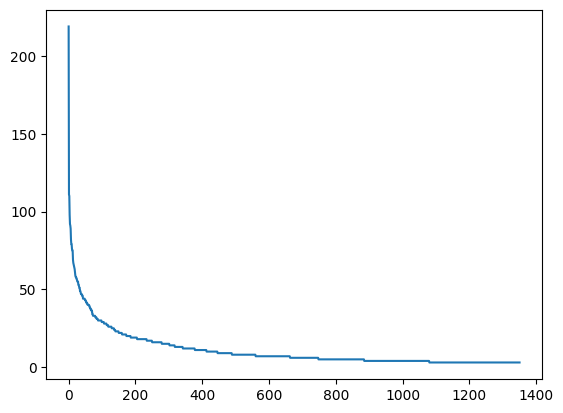

In [52]:
# choose with doc freq > 2
b = df_desc_vocab[df_desc_vocab['doc_freq'] > 2]
# plot doc freq with pandas plot
b.sort_values(by='doc_freq', inplace=True, ascending=False)
b.reset_index(drop=True, inplace=True)
# plot doc freq against index
b['doc_freq'].plot()
#b.shape

In [53]:
descr_tok.from_vocab(b['word'].values, b['freq'].values)

In [ ]:
df_meta['description_token'] = df_meta['description'].apply(descr_tok.tokenize)
df_meta.head(5)

,item_id,title,description,title_token,description_token
0,B0B8M5FJ9W,D'Addario Accessories Locking Guitar Strap - G...,Product Description. Our patented design Plane...,"[0, 0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, ..."
1,B01FM8IN3U,Musiclily Electric Guitar Pickguard Compatible...,,"[2, 4, 9, 10, 11, 12]",[]
2,B0C5LYJXLR,Hosa GXX-145 XLR3F to XLR3F Gender Changer Ada...,Product Description. This adaptor is designed ...,"[13, 14, 15]","[7, 7, 7, 7, 8, 8, 12, 14, 27, 43, 63, 63, 63,..."
3,B07HGRFG5J,IKN 3Ply White Strat Pickguard Backplate Set f...,Note:. 1. The color might be a liitle differen...,"[16, 17, 18, 19, 20, 21, 22, 23]","[65, 82, 99, 110, 163, 254, 260, 286, 373, 400..."
4,B007MY5BDI,D'Addario Guitar Strings - Acoustic Guitar Str...,80/20 Bronze are our brightest acoustic string...,"[2, 2, 2, 5, 24, 24, 24, 25, 26, 27, 28, 29, 3...","[0, 0, 1, 1, 1, 1, 3, 5, 5, 11, 15, 15, 16, 16..."


In [49]:
df_desc_vocab.head(15)

,word_id,word,freq,doc_freq,idf
0,8,guitar,574,219,0.843376
1,94,string,474,111,1.522918
5,244,instrument,208,110,1.531968
3,105,tone,217,98,1.647481
12,260,feature,127,92,1.710659
14,95,made,123,91,1.721589
8,51,quality,138,89,1.743812
9,18,designed,137,82,1.825729
16,0,product,116,79,1.863000
6,346,sound,181,79,1.863000


In [44]:
df_meta.head(5)

,item_id,title,description,title_token,description_token
0,B0B8M5FJ9W,D'Addario Accessories Locking Guitar Strap - G...,Product Description. Our patented design Plane...,"[0, 0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, ...","[0, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
1,B01FM8IN3U,Musiclily Electric Guitar Pickguard Compatible...,,"[2, 4, 9, 10, 11, 12]",[]
2,B0C5LYJXLR,Hosa GXX-145 XLR3F to XLR3F Gender Changer Ada...,Product Description. This adaptor is designed ...,"[13, 14, 15]","[0, 0, 1, 18, 18, 18, 18, 22, 22, 22, 25, 56, ..."
3,B07HGRFG5J,IKN 3Ply White Strat Pickguard Backplate Set f...,Note:. 1. The color might be a liitle differen...,"[16, 17, 18, 19, 20, 21, 22, 23]","[26, 35, 41, 80, 81, 82, 83, 84, 85, 86, 87, 8..."
4,B007MY5BDI,D'Addario Guitar Strings - Acoustic Guitar Str...,80/20 Bronze are our brightest acoustic string...,"[2, 2, 2, 5, 24, 24, 24, 25, 26, 27, 28, 29, 3...","[8, 8, 29, 29, 34, 92, 92, 93, 93, 94, 94, 94,..."


In [ ]:
def calc_tf(doc):
        ret = []
        for term in doc:
            ret.append(doc.count(term)/len(doc))
        return np.array(ret) 


        

,item_id,title,description,description_token,title_token,tfidf_sum,description_token_tfidf_sum
0,B0B8M5FJ9W,D'Addario Accessories Locking Guitar Strap - G...,Product Description. Our patented design Plane...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 2, 0, 4, 2, 3, 5, 2, 3, 5, 4, 2, ...",4.880650,4.880650
1,B01FM8IN3U,Musiclily Electric Guitar Pickguard Compatible...,,[],"[4, 2, 9, 10, 11, 12]",0.000000,0.000000
2,B0C5LYJXLR,Hosa GXX-145 XLR3F to XLR3F Gender Changer Ada...,Product Description. This adaptor is designed ...,"[0, 1, 63, 18, 22, 64, 65, 61, 66, 66, 67, 63,...","[13, 14, 15]",5.818776,5.818776
3,B07HGRFG5J,IKN 3Ply White Strat Pickguard Backplate Set f...,Note:. 1. The color might be a liitle differen...,"[80, 81, 82, 26, 83, 84, 35, 85, 86, 87, 41, 8...","[16, 17, 18, 19, 20, 21, 22, 23]",1.647481,1.647481
4,B007MY5BDI,D'Addario Guitar Strings - Acoustic Guitar Str...,80/20 Bronze are our brightest acoustic string...,"[92, 93, 94, 95, 96, 8, 97, 98, 99, 100, 94, 8...","[2, 24, 5, 2, 24, 25, 24, 2, 26, 27, 28, 29, 3...",3.185520,3.185520
...,...,...,...,...,...,...,...
504,B00V7YMOLG,Faswin 41 Inches Guitar Bag Dual Adjustable Sh...,,[],"[80, 2, 230, 276, 206, 839, 3, 5, 2, 229, 230,...",0.000000,0.000000
505,B0C3Q29DML,JIM DUNLOP Formula 65 Neck Cradle Maintenance ...,We're pretty sure the Dunlop NC65 Maintenance ...,"[2108, 43, 59, 3017, 1343, 1417, 638, 689, 115...","[750, 353, 351, 661, 590]",10.992491,10.992491
506,B000NGVQKO,"3 x Stainless Steel, Open Design, Metal Finger...",Tone Deaf Music Steel Finger Picks (set of 3)....,"[105, 3018, 351, 110, 947, 57, 189, 267, 2420,...","[454, 340, 214, 842, 277, 152, 427, 59, 2, 157...",5.481969,5.481969
507,B00WHLLDWO,Donner DP-1 Guitar Power Supply 10 Isolated DC...,,[],"[2, 112, 504, 568, 186, 81, 82]",0.000000,0.000000


C:\Users\newma\AppData\Local\Temp\ipykernel_11792\3178087278.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b.sort_values(by='doc_freq', inplace=True, ascending=False)


<Axes: >

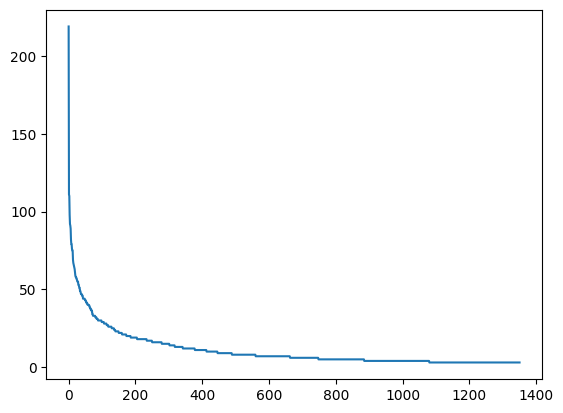

In [38]:
a = np.array([1,2,3])
b = np.array([0,0,0,0,0,0,0] )
x = np.put_along_axis(b, a, [10,20,30], axis=0)
b

array([ 0, 10, 20, 30,  0,  0,  0])

### Word2Vec

In [86]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
C:\Users\newma/gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz


In [4]:
from gensim.models import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('C:\KU\WRS/GoogleNews-vectors-negative300.bin', binary=True)

In [26]:
model.get_vector('king')

array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

In [ ]:
missing = set()
w2v_gog_dict = {}
for words in descr_tok.word2idx_dict().keys():
    try:
        w2v_gog_dict[words] = model.get_vector(words)
    except:
        missing.add(words)
        w2v_gog_dict[words] = np.zeros(300)

for words in title_tok.word2idx_dict().keys():
    try:
        w2v_gog_dict[words] = model.get_vector(words)
    except:
        missing.add(words)
        w2v_gog_dict[words] = np.zeros(300)
    

In [102]:
len(w2v_gog_dict)

3126

In [97]:
missing

{'adaptor',
 'axe',
 'colour',
 'fishman',
 'grey',
 'hipshot',
 'nema',
 'plectron',
 'triboelectric'}

In [ ]:
for words in missing:
    try:
        a = descr_tok._word_freq[words]
    except:
        a = 0
    try:
        b = title_tok._word_freq[words]
    except:
        b = 0
    print(words, a + b)

hipshot 10
axe 2
grey 2
adaptor 9
nema 1
triboelectric 1
colour 3
fishman 1
plectron 3
